In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\aletu\.conda\envs\test\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import data thunderstorm

In [2]:
df = pd.read_csv('https://github.com/ipython-books/'
                 'cookbook-2nd-data/blob/master/'
                 'Allstorms.ibtracs_wmo.v03r05.csv?'
                 'raw=true',
                 delim_whitespace=False)

Text(0, 0.5, 'Number of storms')

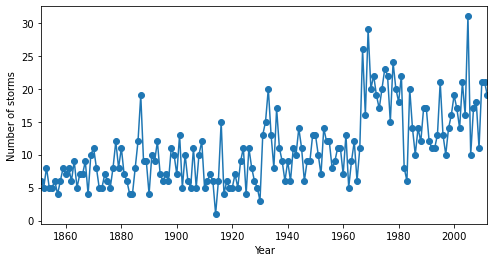

In [3]:
cnt = df[df['Basin'] == ' NA'].groupby(
    'Season')['Serial_Num'].nunique()
# The years from 1851 to 2012.
years = cnt.index
y0, y1 = years[0], years[-1]
arr = cnt.values
# Plot the annual number of storms.
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(years, arr, '-o')
ax.set_xlim(y0, y1)
ax.set_xlabel("Year")
ax.set_ylabel("Number of storms")

In [4]:
# We define our model.
with pm.Model() as model:
    # We define our three variables.
    switchpoint = pm.DiscreteUniform(
        'switchpoint', lower=y0, upper=y1)
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    
    # The rate of the Poisson process is a piecewise
    # constant function.
    rate = pm.math.switch(switchpoint >= years,
                          early_rate, late_rate)
    # The annual number of storms per year follows
    # a Poisson distribution.
    storms = pm.Poisson('storms', rate, observed=arr)

In [7]:
with model:
    trace = pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████████| 6000/6000 [02:07<00:00, 46.91draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020A01240A20>,
      dtype=object)

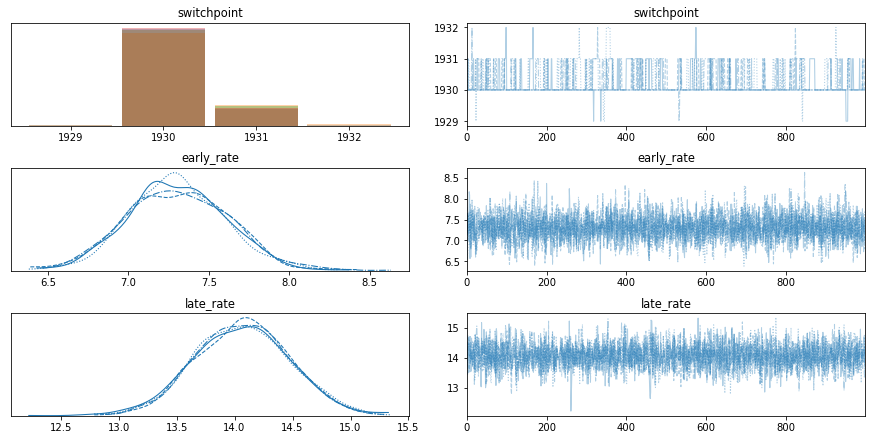

In [8]:
pm.traceplot(trace)

### COVID-19 Italy data

In [36]:
# import all data
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",error_bad_lines=False)
df

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-02-24T18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN
3,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN
4,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,2020-04-30T17:00:00,ITA,9,Toscana,43.769231,11.255889,546,126,672,4912,5584,-79,60,2926,842,9352,141849,108596.0,NaN,NaN
1403,2020-04-30T17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,158,21,179,1191,1370,-93,47,2328,418,4116,36534,21622.0,NaN,NaN
1404,2020-04-30T17:00:00,ITA,10,Umbria,43.106758,12.388247,68,16,84,149,233,-28,1,1092,67,1392,36459,25317.0,NaN,NaN
1405,2020-04-30T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,76,4,80,9,89,-46,4,902,137,1128,7631,5647.0,NaN,NaN


Text(0.5, 1.0, 'Rateo positività')

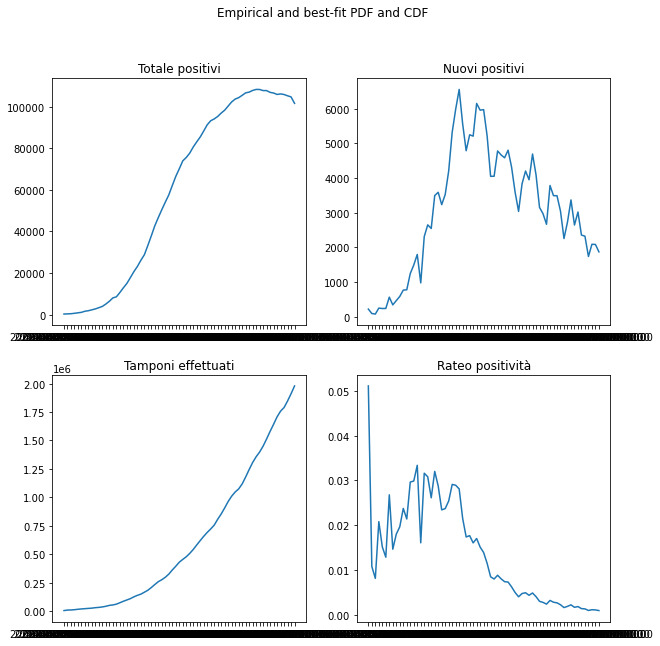

In [44]:
#group by date
df_grouped = df.groupby(['data']).agg({'totale_positivi':['sum'],
                                        'nuovi_positivi':['sum'],
                                        'tamponi':['sum'],
                                        'dimessi_guariti':['sum'],
                                        'deceduti':['sum'],
                                        'totale_casi':['sum']
                                      
                                      }).reset_index()
pos_rate = df_grouped['nuovi_positivi']/df_grouped['tamponi']


#Plot all together for comparison
fig, axs = plt.subplots(2, 2)
plt.rcParams['figure.figsize'] = [10, 10] #[width height] #set figure size
fig.suptitle('Empirical and best-fit PDF and CDF')

#plot totale positivi
axs[0,0].plot(df_grouped['data'],df_grouped['totale_positivi'])
axs[0,0].set_title("Totale positivi")


axs[0,1].plot(df_grouped['data'],df_grouped['nuovi_positivi'])
axs[0,1].set_title("Nuovi positivi")


axs[1,0].plot(df_grouped['data'],df_grouped['tamponi'])
axs[1,0].set_title("Tamponi effettuati")


axs[1,1].plot(df_grouped['data'],pos_rate)
axs[1,1].set_title("Rateo positività")




In [65]:
mu = np.mean(pos_rate)
std = np.std(pos_rate)
print(mu)
print(std)

obs = df_grouped['totale_positivi'][10:]

sum    0.014619
dtype: float64
sum    0.011163
dtype: float64


In [70]:
# We define our model.
with pm.Model() as model:
    positivity_rate = pm.Logistic('positivity_rate')
    #alpha = pm.Uniform('alpha', lower=0, upper=100)
    totale_positivi = pm.Exponential('totale positivi',lam=positivity_rate,observed=obs)
    #totale_positivi_reale = totale_positivi*alpha
    

In [71]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [positivity_rate]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 6000/6000 [00:45<00:00, 131.27draws/s]
The acceptance probability does not match the target. It is 0.9382981677627882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.952786152814099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9517243498801028, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9342040182650432, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020A071884A8>,
      dtype=object)

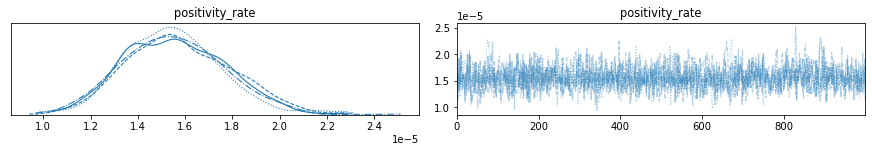

In [72]:
pm.traceplot(trace)

### Test area

Text(0.5, 1.0, 'Exponential propagation with $R_0=0.1$')

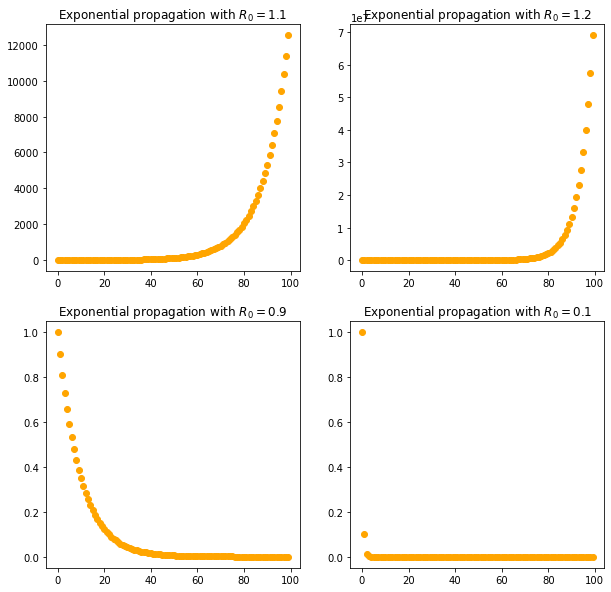

In [31]:
#Example of an exponential model
def expo_model(x, R0):
    return R0**x


#Examples with different propagation coefficients
fig, axs = plt.subplots(2, 2)


#Propagation coefficients greater than 1
R0=1.1
time = np.arange(0,100)
y = expo_model(time,R0)
axs[0,0].scatter(time, y,c='orange')
axs[0,0].set_title(f"Exponential propagation with $R_0={R0}$")


R0=1.2
time = np.arange(0,100)
y = expo_model(time,R0)
axs[0,1].scatter(time, y,c='orange')
axs[0,1].set_title(f"Exponential propagation with $R_0={R0}$")


#Propagation coefficients less than 1
R0=0.9
time = np.arange(0,100)
y = expo_model(time,R0)
axs[1,0].scatter(time, y,c='orange')
axs[1,0].set_title(f"Exponential propagation with $R_0={R0}$")


R0=0.1
time = np.arange(0,100)
y = expo_model(time,R0)
axs[1,1].scatter(time, y,c='orange')
axs[1,1].set_title(f"Exponential propagation with $R_0={R0}$")



In [33]:
#Definition of R0
tau = 0.5 #infection/contact (probability of infection given contact between a susceptible and infected individual)
c_bar = 0.5 #contact/time ( average rate of contact between susceptible and infected individuals)
d = 2 #time/infection ( duration of infectiousness)
N = 100 #population size
S = 19 #susceptible
I = 10 #infected
R = 4 #removed

s = S/N

i = I/N

r = R/N

#ds/dt = -betasi
#di/dt = betasi - vi 
#dr/dt = vi




beta = tau*c_bar
R0 = tau*c_bar*d


0.5

Mean: sum    3066.492537
dtype: float64
Std: sum    1754.413023
dtype: float64


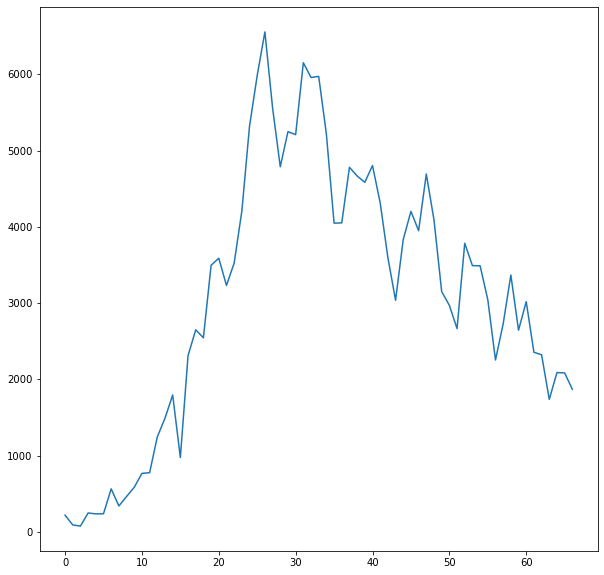

In [49]:
# modello il numero degli infetti
#di/dt is the observed number of new infections
obs_di_dt = df_grouped['nuovi_positivi']
plt.plot(obs_di_dt)

#assume being normal
obs_di_dt_mean = np.mean(obs_di_dt)
obs_di_dt_std = np.std(obs_di_dt)

print(f"Mean: {obs_di_dt_mean}")
print(f"Std: {obs_di_dt_std}")

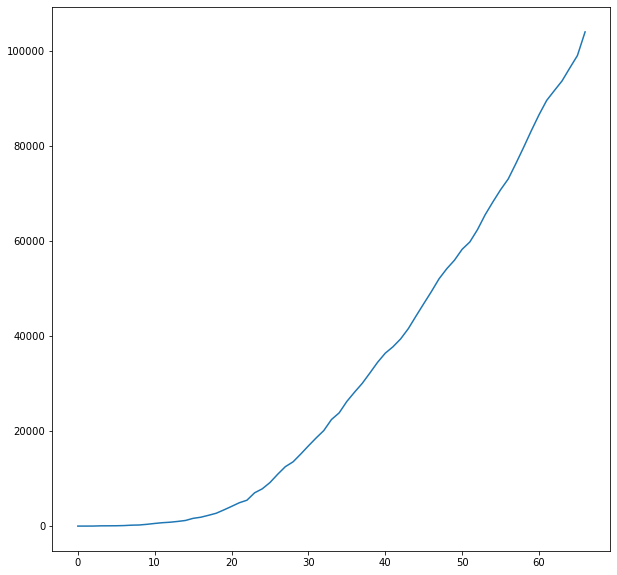

In [38]:
# model the number of removed
#dr/dt = is the number of new removed

obs_dr_dt = df_grouped['dimessi_guariti'] + df_grouped['deceduti']
plt.plot(obs_dr_dt)

#assume exponential



In [ ]:
# model the number of susceptible
#ds/dt = is the number of new susceptible   ????????????

In [41]:
# model the number of individuals of the population
# Assume N being costant (the whole italian population)
N=60e6

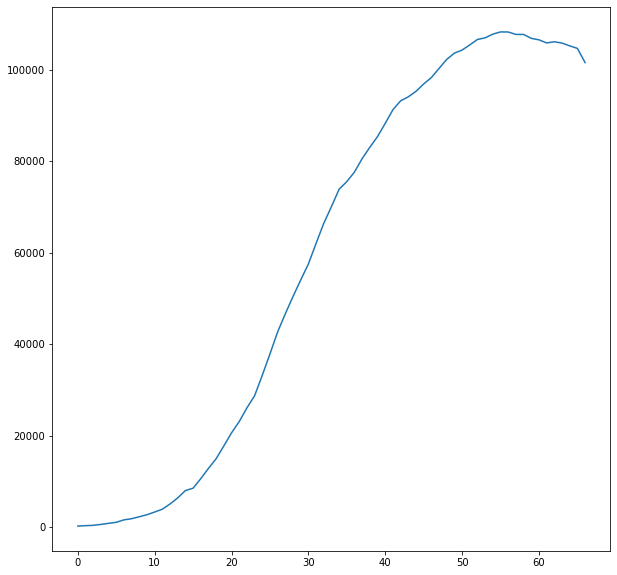

In [42]:
# model the number of infected I
obs_I = df_grouped['totale_positivi']
plt.plot(obs_I)


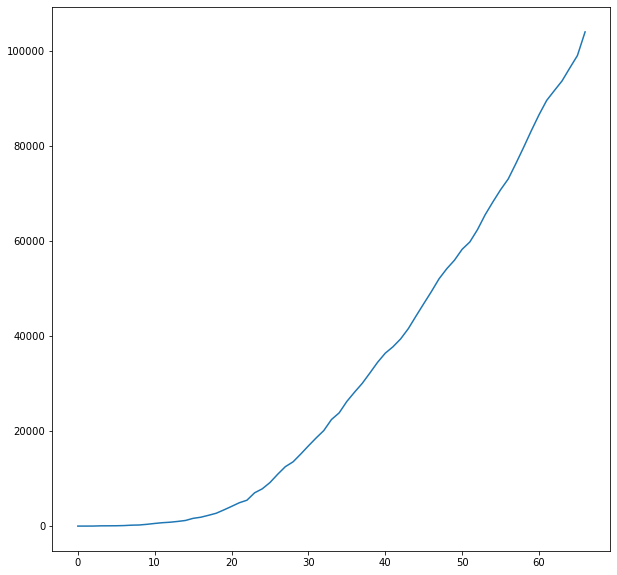

In [45]:
# model the number of removed R
obs_R = df_grouped['totale_casi'] - df_grouped['totale_positivi']
plt.plot(obs_R)

In [50]:
# We define our model.
with pm.Model() as model:
    infected_rate = pm.Normal('di_dt', mu = obs_di_dt_mean, sigma= obs_di_dt_std, observed = obs_di_dt)
    removed_rate = pm.Exponential('dr_dt', observed = obs_dr_dt)
    susceptibilty_rate = -infected_rate - removed_rate
    

TypeError: __init__() missing 1 required positional argument: 'lam'

In [ ]:
#https://sciencecue.it/coronavirus-modello-matematico-evoluzione/18355/
#https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf